## Contents
* [1. Improved Model](#1.-Improved-Model)
* [2. Imports](#2.-Imports)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Model Fit & Predict](#4.-Model-Fit-&-Predict)
    * [4.1 Model 2](#4.1-Model-2)
    * [4.2 Model 3](#4.2-Model-3)
    * [4.3 Model 4](#4.3-Model-4)
* [5. Remarks](#5.-Remarks)

---
## 1. Improved Model
---
Objective: to compare the weighted-average ROC AUC scores and f1-scores (kf, lca) of the following models:

|                                     | Model 1<br>(from notebook 3) | Model 2       | Model 3  | Model 4 |
|-------------------------------------|----------------------------|---------------|----------|---------|
| Vectoriser                          | TFIDF                      | TFIDF         | TFIDF    | TFIDF   |
| Model                               | Multinomial Naive Bayes    | Random Forest | XGBoost | SVM     |

Note: the code below was ran on Kaggle, to make use of Kaggle GPUs.

---
## 2. Imports
---

In [2]:
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier as ovr

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

---
## 3. Data Cleaning & Preparation
---

- read CSV files

In [3]:
kf_df = pd.read_csv('/kaggle/input/sq-services/kf_clean.csv')
lca_df = pd.read_csv('/kaggle/input/sq-services/LCA_clean.csv')
other_df = pd.read_csv('/kaggle/input/sq-services/other_clean.csv')
kf_df.head()

,text,source
0,Qualifying as EG for the first time,kf
1,Which FFP for me? Master Discussion,kf
2,#SQMelbourneTram,kf
3,Advice sought - Changing redemption bookings,kf
4,First Savers SYD-SIN,kf


- find and resolve NA values

In [4]:
services_df = pd.concat([kf_df, lca_df, other_df])

print(services_df.isna().sum())

# acceptable to drop 3 NA values out of 44k values
services_df.dropna(inplace=True)
# reset index, and drop old index
services_df.reset_index(drop=True, inplace=True)

print(services_df.isna().sum())

text      3
source    0
dtype: int64
text      0
source    0
dtype: int64


- create a 'kf' column: 
    - if value = 0, the source is others
    - if value = 1, the source is kf
    - if value = 2, the source is from LCA

In [5]:
services_df['y_true'] = services_df['source'].map({'other':0, 'kf': 1, 'lca': 2})
services_df['y_true'].value_counts(normalize=True)

1    0.402724
0    0.353570
2    0.243706
Name: y_true, dtype: float64

- stem text and stopwords

In [6]:
stemmer = PorterStemmer()

In [7]:
def token_stem(sent):
    result = []
    list = word_tokenize(sent)
    for word in list:
        result.append(stemmer.stem(word))
    return ' '.join(result)

In [8]:
services_stem_df = services_df.copy()
services_stem_df['text'] = [token_stem(text) for text in services_df['text']]
services_stem_df.head()

,text,source,y_true
0,qualifi as eg for the first time,kf,1
1,which ffp for me ? master discuss,kf,1
2,# sqmelbournetram,kf,1
3,advic sought - chang redempt book,kf,1
4,first saver syd-sin,kf,1


In [9]:
cvec = CountVectorizer(max_features = 500, stop_words = 'english') 
stem_stopwords = [stemmer.stem(word) for word in cvec.get_stop_words()]
stem_stopwords.extend([stemmer.stem(word) for word in ['btw','iirc','imo','imho']])

---
## 4. Model Fit & Predict
---

## 4.1 Model 2
### - Random Forest

- train-test-split our df

In [10]:
X = services_stem_df['text']
y = services_stem_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    doe kf actual explain the differ in qualifi da...
29195    bkk airport close : sq et al cancel flight 26 ...
22061    origin post by sq lppview postthat 's a veri g...
6624     origin post by glam82view posti there a better...
20643    i would have thought they will use the skl , s...
                               ...                        
12020    origin post by cgkview post sq prefer i stay i...
43382    i thought i 'd get your view on thi , which is...
1598     origin post by florianwagnerview postso would ...
11541               letter date 19 march receiv 28 march .
22264    sorri to report that as i got to sfo airport f...
Name: text, Length: 33095, dtype: object

- create pipeline for GridSearchCV later

In [15]:
pipe_rf = make_pipeline(
    TfidfVectorizer(),
    rfc(random_state=42)
)
pipe_rf.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'randomforestclassifier': RandomForestClassifier(random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer':

In [16]:
pipe_rf_params = {'tfidfvectorizer__max_features': [300,500],
                  'tfidfvectorizer__stop_words': [None,stem_stopwords],
                  'randomforestclassifier__max_depth': [5,10],
                  'randomforestclassifier__min_samples_leaf': [3,5],
                  'randomforestclassifier__ccp_alpha': [0,1]
                 }

- GridSearchCV

In [17]:
pipe_rf_gs = GridSearchCV(pipe_rf, pipe_rf_params)
pipe_rf_gs.fit(X_train, y_train)
print(pipe_rf_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['meanwhil', 'it', 'be', 'detail',
                                             'up', 'part', 'well', 'herebi',
                                             'give', 'first', 'until',
                                             'whereaft', 'behind', 'inc',
                                             'about', 'along', 'seem', 'veri',
                                             'hasnt', 'could', 'without', 'you',
                                             'one', 'etc', 'then', 'becom',
                                             'himself', 'may', 'ie', 'nor', ...])),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0, max_depth=10,
                                        min_samples_leaf=3, random_state=42))])


- visualise confusion matrix

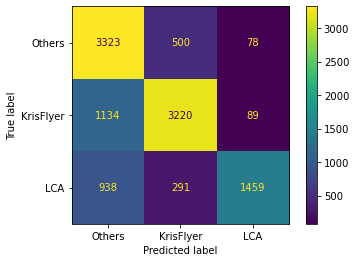

In [18]:
y_pred = pipe_rf_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [19]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.62      0.85      0.71      3901
           1       0.80      0.72      0.76      4443
           2       0.90      0.54      0.68      2688

    accuracy                           0.73     11032
   macro avg       0.77      0.71      0.72     11032
weighted avg       0.76      0.73      0.72     11032



- display the weighted average ROC AUC score

In [20]:
y_pred_prob = pipe_rf_gs.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.8827979263996367

- weighted f1-score of KrisFlyer and LCA

In [21]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.7190859936437493

## 4.2 Model 3
### - XGBoost

- create pipeline for GridSearchCV later

In [22]:
pipe_xgb = make_pipeline(
    TfidfVectorizer(),
    XGBClassifier(seed=42)
)
pipe_xgb.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, gamma=None,
                 gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, n_estimators=100, n_jobs=None,
                 num_parallel_tree=None, predictor=None, random_state=None,
                 reg_alpha=None, reg_lambda=None, ...))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None

- pick xgb params based on [XGBoost fine tuning](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663), limited by time spent on training

In [23]:
pipe_xgb_params = {'tfidfvectorizer__max_features': [300,500],
                   'tfidfvectorizer__stop_words': [None,stem_stopwords],
                   'xgbclassifier__max_depth': [3,6],
                   'xgbclassifier__n_estimators': [100,200]
                  }

- GridSearchCV

In [24]:
pipe_xgb_gs = GridSearchCV(pipe_xgb, pipe_xgb_params)
pipe_xgb_gs.fit(X_train, y_train)
print(pipe_xgb_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['meanwhil', 'it', 'be', 'detail',
                                             'up', 'part', 'well', 'herebi',
                                             'give', 'first', 'until',
                                             'whereaft', 'behind', 'inc',
                                             'about', 'along', 'seem', 'veri',
                                             'hasnt', 'could', 'without', 'you',
                                             'one', 'etc', 'then', 'becom',
                                             'himself', 'may', 'ie', 'nor', ...])),
                ('xgbclassifier',
                 XGBClassifier(base_scor...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012,

- visualise confusion matrix

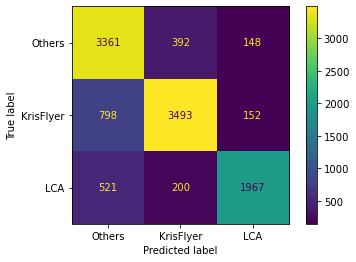

In [25]:
y_pred = pipe_xgb_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [26]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      3901
           1       0.86      0.79      0.82      4443
           2       0.87      0.73      0.79      2688

    accuracy                           0.80     11032
   macro avg       0.81      0.79      0.80     11032
weighted avg       0.81      0.80      0.80     11032



- display the weighted average ROC AUC score

In [27]:
y_pred_prob = pipe_xgb_gs.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.9250107935535378

- weighted f1-score of KrisFlyer and LCA

In [28]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.8065646872509245

## 4.3 Model 4
### - SVM

- create pipeline for GridSearchCV later

In [11]:
pipe_svm = make_pipeline(
    TfidfVectorizer(),
    SVC(random_state=42)
)
pipe_svm.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('svc', SVC(random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'svc': SVC(random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': No

In [13]:
pipe_svm_params = {'tfidfvectorizer__max_features': [300,500],
                   'tfidfvectorizer__stop_words': [None,stem_stopwords],
                   'svc__C': [0.1,1],
                   'svc__gamma': [1,0.1]
                  }

- GridSearchCV

In [15]:
pipe_svm_gs = GridSearchCV(pipe_svm, pipe_svm_params)
pipe_svm_gs.fit(X_train, y_train)
print(pipe_svm_gs.best_estimator_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['therebi', 'ha', 'call', 'not',
                                             'our', 'well', 'among', 'former',
                                             'everyth', 'our', 'often', 'ever',
                                             'if', 'more', 'below', 'everyon',
                                             'latterli', 'hereaft', 'moreov',
                                             'or', 'sometim', 'though',
                                             'nowher', 'it', 'six', 'me',
                                             'here', 'it', 'seem', 'neither', ...])),
                ('svc', SVC(C=1, gamma=1, random_state=42))])


- train the best SVM estimator, with 'probability' parameter as True
- this is done separately from GridSearchCV above, as the SVM algo will conduct a 5-fold cross-validation and slow down significantly
- with 'probability' parameter = True, I can use predict_proba later to derive the ROC AUC score

In [16]:
# create another SVM pipe with the best params
pipe_svm_best = make_pipeline(
    TfidfVectorizer(max_features=500, stop_words=stem_stopwords),
    SVC(C=1, gamma=1,probability=True, random_state=42)
)

In [17]:
pipe_svm_best.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['therebi', 'ha', 'call', 'not',
                                             'our', 'well', 'among', 'former',
                                             'everyth', 'our', 'often', 'ever',
                                             'if', 'more', 'below', 'everyon',
                                             'latterli', 'hereaft', 'moreov',
                                             'or', 'sometim', 'though',
                                             'nowher', 'it', 'six', 'me',
                                             'here', 'it', 'seem', 'neither', ...])),
                ('svc', SVC(C=1, gamma=1, probability=True, random_state=42))])

- visualise confusion matrix

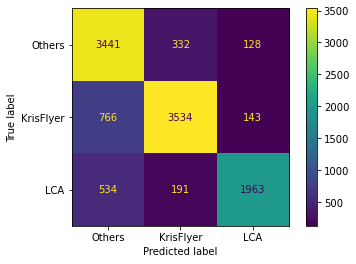

In [18]:
y_pred = pipe_svm_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [19]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      3901
           1       0.87      0.80      0.83      4443
           2       0.88      0.73      0.80      2688

    accuracy                           0.81     11032
   macro avg       0.83      0.80      0.81     11032
weighted avg       0.82      0.81      0.81     11032



- display the weighted average ROC AUC score

In [20]:
y_pred_prob = pipe_svm_best.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.9253690479453621

- weighted f1-score of KrisFlyer and LCA

In [21]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.8145863231111218

---
## 5. Remarks
---

|                                     | Model 1<br>(from notebook 3) | Model 2       | Model 3  | Model 4<br>\*Best performance\* |
|-------------------------------------|----------------------------|---------------|----------|---------|
| Vectoriser                          | TFIDF                      | TFIDF         | TFIDF    | TFIDF   |
| Model                               | Multinomial Naive Bayes    | Random Forest | XGBoost | SVM     |
| Macro-average ROC AUC            | 0.908                      | 0.883         | 0.925    | 0.925   |
| Macro-average f1-score (kf, lca) | 0.759                      | 0.719         | 0.807    | 0.815    |

- Model 4 performed the best with the following params:
    - TfidfVectorizer(max_features=500, stop_words=stem_stopwords)
    - SVC(C=1, gamma=1, probability=True, random_state=42)
<br>
<br>
- although model 3 and model 4 have the the same macro-average ROC AUC score, model 3 edged out in its macro-average f1-score. This meant that model 3 has the least false-positive and false-negative prediction for KF and LCA, which is important to the business